# Gans-UNNative

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd
import os

In [ ]:
# Here, we store the directory path
DATA_DIR='/input/maskdata'

In [ ]:
# count number of images
lst = os.listdir("/input/maskdata/with_mask")
number_files = len(lst)
print(number_files)

3725


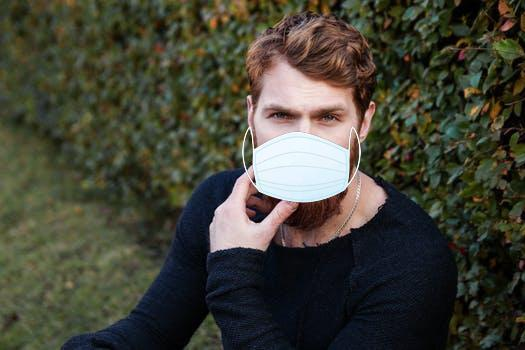

(350, 525, 3)


In [ ]:
# showing some examples with their size
from IPython.display import Image, display
import cv2
image = cv2.imread("/input/maskdata/with_mask/with_mask_1.jpg")
display(Image(filename="/input/maskdata/with_mask/with_mask_1.jpg"))
print(image.shape)

## preprocesing


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# Using the ImageFolder class from torchvision with transform.
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

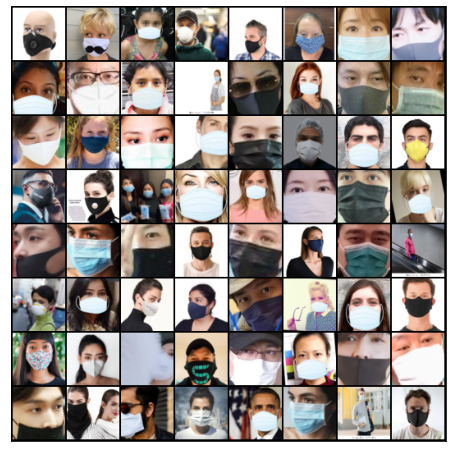

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


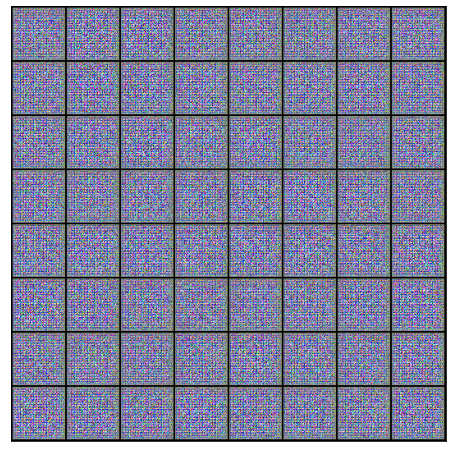

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


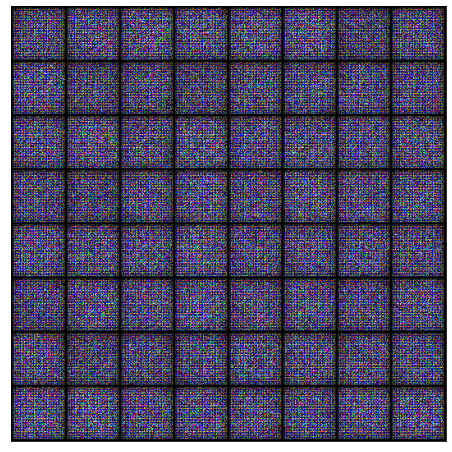

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/100], loss_g: 13.8291, loss_d: 0.6576, real_score: 0.6341, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [2/100], loss_g: 13.8701, loss_d: 0.1905, real_score: 0.8486, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [3/100], loss_g: 5.8005, loss_d: 0.1028, real_score: 0.9640, fake_score: 0.0625
Saving generated-images-0003.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [4/100], loss_g: 3.4975, loss_d: 0.3117, real_score: 0.8332, fake_score: 0.1149
Saving generated-images-0004.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [5/100], loss_g: 1.8804, loss_d: 0.6996, real_score: 0.6585, fake_score: 0.2049
Saving generated-images-0005.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [6/100], loss_g: 1.8065, loss_d: 0.6940, real_score: 0.7234, fake_score: 0.2482
Saving generated-images-0006.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [7/100], loss_g: 3.5130, loss_d: 0.3480, real_score: 0.8842, fake_score: 0.1691
Saving generated-images-0007.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [8/100], loss_g: 8.3827, loss_d: 0.7316, real_score: 0.9099, fake_score: 0.4091
Saving generated-images-0008.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [9/100], loss_g: 5.1821, loss_d: 0.5757, real_score: 0.9390, fake_score: 0.3725
Saving generated-images-0009.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [10/100], loss_g: 0.6016, loss_d: 1.2291, real_score: 0.4187, fake_score: 0.1261
Saving generated-images-0010.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [11/100], loss_g: 3.2202, loss_d: 0.5422, real_score: 0.8274, fake_score: 0.2427
Saving generated-images-0011.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [12/100], loss_g: 2.8579, loss_d: 0.4787, real_score: 0.8511, fake_score: 0.2552
Saving generated-images-0012.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [13/100], loss_g: 3.3901, loss_d: 0.4133, real_score: 0.9052, fake_score: 0.2405
Saving generated-images-0013.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [14/100], loss_g: 2.1884, loss_d: 0.6566, real_score: 0.5857, fake_score: 0.0323
Saving generated-images-0014.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [15/100], loss_g: 2.9208, loss_d: 0.3862, real_score: 0.7653, fake_score: 0.0872
Saving generated-images-0015.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [16/100], loss_g: 3.1790, loss_d: 0.3963, real_score: 0.9660, fake_score: 0.2742
Saving generated-images-0016.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [17/100], loss_g: 3.7901, loss_d: 0.5473, real_score: 0.7902, fake_score: 0.2441
Saving generated-images-0017.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [18/100], loss_g: 2.1735, loss_d: 0.6542, real_score: 0.5678, fake_score: 0.0338
Saving generated-images-0018.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [19/100], loss_g: 0.9152, loss_d: 1.0513, real_score: 0.4701, fake_score: 0.1602
Saving generated-images-0019.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [20/100], loss_g: 1.9405, loss_d: 0.3744, real_score: 0.9090, fake_score: 0.2215
Saving generated-images-0020.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [21/100], loss_g: 4.0351, loss_d: 0.1879, real_score: 0.9333, fake_score: 0.1048
Saving generated-images-0021.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [22/100], loss_g: 4.1040, loss_d: 0.3990, real_score: 0.8906, fake_score: 0.2179
Saving generated-images-0022.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [23/100], loss_g: 4.7052, loss_d: 0.6122, real_score: 0.8861, fake_score: 0.3521
Saving generated-images-0023.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [24/100], loss_g: 5.1965, loss_d: 0.2265, real_score: 0.8694, fake_score: 0.0636
Saving generated-images-0024.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [25/100], loss_g: 3.5589, loss_d: 0.2147, real_score: 0.8666, fake_score: 0.0623
Saving generated-images-0025.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [26/100], loss_g: 1.6329, loss_d: 1.0781, real_score: 0.5917, fake_score: 0.3328
Saving generated-images-0026.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [27/100], loss_g: 0.7627, loss_d: 0.8844, real_score: 0.4761, fake_score: 0.0326
Saving generated-images-0027.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [28/100], loss_g: 4.3498, loss_d: 0.4357, real_score: 0.9530, fake_score: 0.2875
Saving generated-images-0028.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [29/100], loss_g: 4.8495, loss_d: 0.3549, real_score: 0.9354, fake_score: 0.2225
Saving generated-images-0029.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [30/100], loss_g: 3.2955, loss_d: 0.3436, real_score: 0.8732, fake_score: 0.1770
Saving generated-images-0030.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [31/100], loss_g: 3.9148, loss_d: 0.3138, real_score: 0.8257, fake_score: 0.1035
Saving generated-images-0031.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [32/100], loss_g: 2.3875, loss_d: 0.4899, real_score: 0.6963, fake_score: 0.0781
Saving generated-images-0032.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [33/100], loss_g: 2.6408, loss_d: 0.2934, real_score: 0.7968, fake_score: 0.0479
Saving generated-images-0033.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [34/100], loss_g: 2.2326, loss_d: 0.6907, real_score: 0.7737, fake_score: 0.2957
Saving generated-images-0034.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [35/100], loss_g: 3.0490, loss_d: 0.4725, real_score: 0.8813, fake_score: 0.2605
Saving generated-images-0035.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [36/100], loss_g: 1.7957, loss_d: 0.3936, real_score: 0.7907, fake_score: 0.1171
Saving generated-images-0036.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [37/100], loss_g: 4.0075, loss_d: 0.2537, real_score: 0.9529, fake_score: 0.1734
Saving generated-images-0037.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [38/100], loss_g: 1.4587, loss_d: 0.4993, real_score: 0.7218, fake_score: 0.1022
Saving generated-images-0038.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [39/100], loss_g: 4.4043, loss_d: 0.2410, real_score: 0.8226, fake_score: 0.0323
Saving generated-images-0039.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [40/100], loss_g: 5.7051, loss_d: 0.8812, real_score: 0.9766, fake_score: 0.4825
Saving generated-images-0040.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [41/100], loss_g: 2.2835, loss_d: 0.3699, real_score: 0.8178, fake_score: 0.1378
Saving generated-images-0041.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [42/100], loss_g: 3.4951, loss_d: 0.4276, real_score: 0.8707, fake_score: 0.2165
Saving generated-images-0042.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [43/100], loss_g: 4.3786, loss_d: 0.3414, real_score: 0.9557, fake_score: 0.2313
Saving generated-images-0043.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [44/100], loss_g: 2.1803, loss_d: 0.4710, real_score: 0.7394, fake_score: 0.1143
Saving generated-images-0044.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [45/100], loss_g: 2.3854, loss_d: 0.3082, real_score: 0.7907, fake_score: 0.0371
Saving generated-images-0045.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [46/100], loss_g: 1.3162, loss_d: 0.5281, real_score: 0.6506, fake_score: 0.0462
Saving generated-images-0046.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [47/100], loss_g: 2.3590, loss_d: 0.4162, real_score: 0.7624, fake_score: 0.0999
Saving generated-images-0047.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [48/100], loss_g: 4.2855, loss_d: 0.1836, real_score: 0.9606, fake_score: 0.1270
Saving generated-images-0048.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [49/100], loss_g: 2.3520, loss_d: 0.7593, real_score: 0.6891, fake_score: 0.2614
Saving generated-images-0049.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [50/100], loss_g: 3.5760, loss_d: 0.3163, real_score: 0.8713, fake_score: 0.1489
Saving generated-images-0050.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [51/100], loss_g: 3.7611, loss_d: 0.2310, real_score: 0.8542, fake_score: 0.0653
Saving generated-images-0051.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [52/100], loss_g: 3.9618, loss_d: 0.3009, real_score: 0.9415, fake_score: 0.1973
Saving generated-images-0052.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [53/100], loss_g: 1.9083, loss_d: 0.7895, real_score: 0.5133, fake_score: 0.0350
Saving generated-images-0053.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [54/100], loss_g: 3.8246, loss_d: 0.1281, real_score: 0.9295, fake_score: 0.0475
Saving generated-images-0054.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [55/100], loss_g: 4.0511, loss_d: 0.4524, real_score: 0.8960, fake_score: 0.2561
Saving generated-images-0055.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [56/100], loss_g: 0.6773, loss_d: 1.0071, real_score: 0.5170, fake_score: 0.1368
Saving generated-images-0056.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [57/100], loss_g: 2.8740, loss_d: 0.4886, real_score: 0.8130, fake_score: 0.1946
Saving generated-images-0057.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [58/100], loss_g: 4.3179, loss_d: 0.2146, real_score: 0.9468, fake_score: 0.1383
Saving generated-images-0058.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [59/100], loss_g: 4.1570, loss_d: 1.0768, real_score: 0.9263, fake_score: 0.5406
Saving generated-images-0059.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [60/100], loss_g: 0.8051, loss_d: 0.7475, real_score: 0.5403, fake_score: 0.0654
Saving generated-images-0060.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [61/100], loss_g: 2.3531, loss_d: 0.4200, real_score: 0.7450, fake_score: 0.0934
Saving generated-images-0061.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [62/100], loss_g: 3.0597, loss_d: 0.3899, real_score: 0.8676, fake_score: 0.2018
Saving generated-images-0062.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [63/100], loss_g: 3.5215, loss_d: 0.3560, real_score: 0.8573, fake_score: 0.1643
Saving generated-images-0063.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [64/100], loss_g: 3.8111, loss_d: 0.1666, real_score: 0.9682, fake_score: 0.1193
Saving generated-images-0064.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [65/100], loss_g: 3.8467, loss_d: 0.2228, real_score: 0.9796, fake_score: 0.1685
Saving generated-images-0065.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [66/100], loss_g: 2.9332, loss_d: 1.3462, real_score: 0.7109, fake_score: 0.4085
Saving generated-images-0066.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [67/100], loss_g: 3.0637, loss_d: 0.5236, real_score: 0.8283, fake_score: 0.2529
Saving generated-images-0067.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [68/100], loss_g: 2.0022, loss_d: 0.4440, real_score: 0.7452, fake_score: 0.0933
Saving generated-images-0068.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [69/100], loss_g: 0.8826, loss_d: 0.5901, real_score: 0.6346, fake_score: 0.0530
Saving generated-images-0069.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [70/100], loss_g: 0.9690, loss_d: 0.6398, real_score: 0.6094, fake_score: 0.0536
Saving generated-images-0070.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [71/100], loss_g: 2.0485, loss_d: 0.4105, real_score: 0.7204, fake_score: 0.0414
Saving generated-images-0071.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [72/100], loss_g: 3.1704, loss_d: 0.2272, real_score: 0.9420, fake_score: 0.1435
Saving generated-images-0072.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [73/100], loss_g: 3.8586, loss_d: 0.2673, real_score: 0.8365, fake_score: 0.0683
Saving generated-images-0073.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [74/100], loss_g: 1.9376, loss_d: 0.3874, real_score: 0.8119, fake_score: 0.1237
Saving generated-images-0074.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [75/100], loss_g: 3.1760, loss_d: 0.3090, real_score: 0.8007, fake_score: 0.0437
Saving generated-images-0075.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [76/100], loss_g: 4.4827, loss_d: 0.1191, real_score: 0.9682, fake_score: 0.0780
Saving generated-images-0076.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [77/100], loss_g: 3.5593, loss_d: 0.2555, real_score: 0.9032, fake_score: 0.1329
Saving generated-images-0077.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [78/100], loss_g: 2.1765, loss_d: 0.5283, real_score: 0.6678, fake_score: 0.0575
Saving generated-images-0078.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [79/100], loss_g: 0.9885, loss_d: 0.5046, real_score: 0.6604, fake_score: 0.0391
Saving generated-images-0079.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [80/100], loss_g: 3.0372, loss_d: 0.2575, real_score: 0.9155, fake_score: 0.1403
Saving generated-images-0080.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [81/100], loss_g: 2.8714, loss_d: 0.1643, real_score: 0.9328, fake_score: 0.0857
Saving generated-images-0081.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [82/100], loss_g: 0.6297, loss_d: 0.4538, real_score: 0.6768, fake_score: 0.0309
Saving generated-images-0082.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [83/100], loss_g: 2.6621, loss_d: 0.2931, real_score: 0.8530, fake_score: 0.1131
Saving generated-images-0083.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [84/100], loss_g: 1.8335, loss_d: 0.3263, real_score: 0.8288, fake_score: 0.1070
Saving generated-images-0084.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [85/100], loss_g: 1.4269, loss_d: 0.4161, real_score: 0.7392, fake_score: 0.0618
Saving generated-images-0085.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [86/100], loss_g: 3.9564, loss_d: 0.1710, real_score: 0.9484, fake_score: 0.1042
Saving generated-images-0086.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [87/100], loss_g: 2.5075, loss_d: 0.2377, real_score: 0.8134, fake_score: 0.0220
Saving generated-images-0087.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [88/100], loss_g: 4.1795, loss_d: 0.1009, real_score: 0.9497, fake_score: 0.0445
Saving generated-images-0088.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [89/100], loss_g: 0.4460, loss_d: 0.4516, real_score: 0.7259, fake_score: 0.0599
Saving generated-images-0089.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [90/100], loss_g: 2.0201, loss_d: 0.5481, real_score: 0.6597, fake_score: 0.0561
Saving generated-images-0090.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [91/100], loss_g: 3.9762, loss_d: 0.1555, real_score: 0.9927, fake_score: 0.1264
Saving generated-images-0091.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [92/100], loss_g: 3.3756, loss_d: 0.1036, real_score: 0.9376, fake_score: 0.0352
Saving generated-images-0092.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [93/100], loss_g: 2.6474, loss_d: 0.2735, real_score: 0.8022, fake_score: 0.0313
Saving generated-images-0093.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [94/100], loss_g: 2.0764, loss_d: 0.2464, real_score: 0.8499, fake_score: 0.0686
Saving generated-images-0094.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [95/100], loss_g: 4.4809, loss_d: 0.4397, real_score: 0.9539, fake_score: 0.2739
Saving generated-images-0095.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [96/100], loss_g: 2.0282, loss_d: 0.2818, real_score: 0.8408, fake_score: 0.0858
Saving generated-images-0096.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [97/100], loss_g: 4.6136, loss_d: 0.2175, real_score: 0.9672, fake_score: 0.1528
Saving generated-images-0097.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [98/100], loss_g: 2.2395, loss_d: 0.2045, real_score: 0.8523, fake_score: 0.0389
Saving generated-images-0098.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [99/100], loss_g: 0.8823, loss_d: 0.2731, real_score: 0.8154, fake_score: 0.0295
Saving generated-images-0099.png


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [100/100], loss_g: 2.3011, loss_d: 0.5283, real_score: 0.6716, fake_score: 0.0153
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

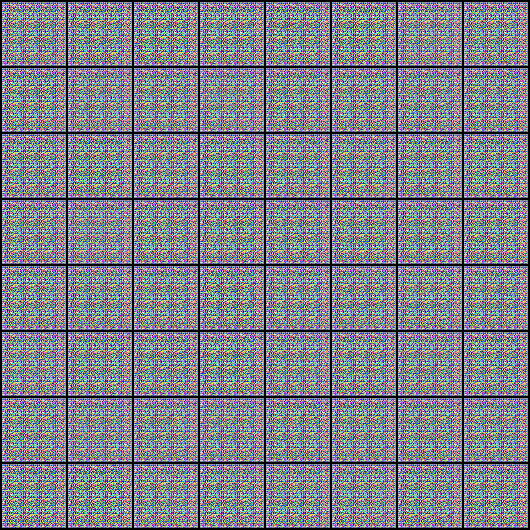

In [ ]:
Image('./generated/generated-images-0001.png')

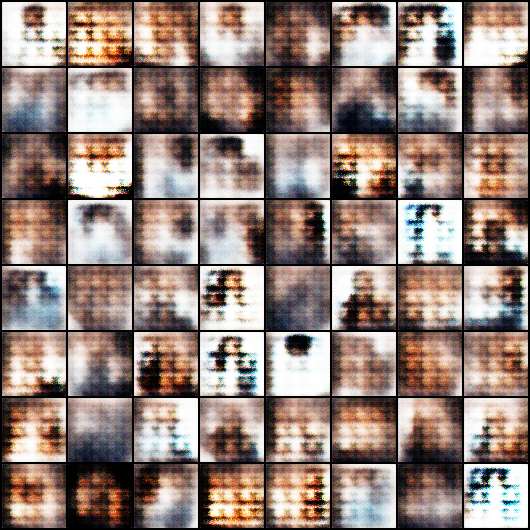

In [ ]:
Image('./generated/generated-images-0010.png')

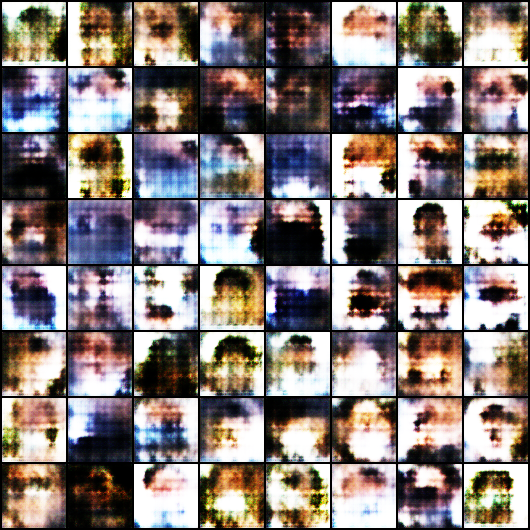

In [ ]:
Image('./generated/generated-images-0020.png')

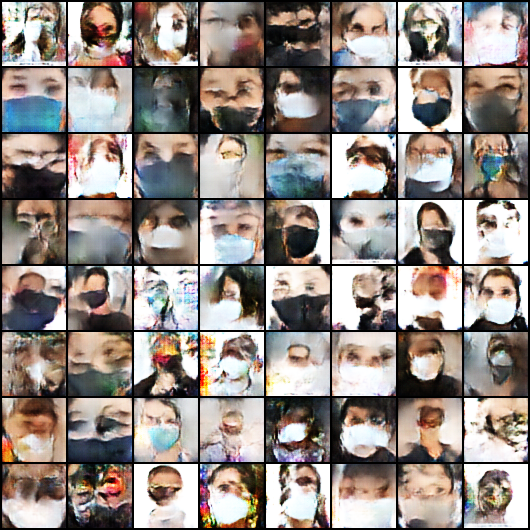

In [ ]:
Image('./generated/generated-images-0100.png')

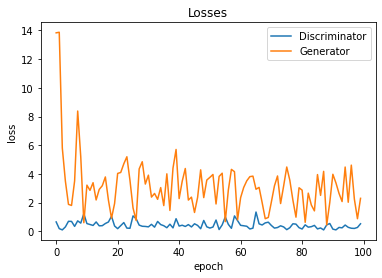

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

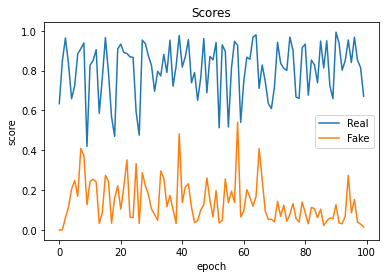

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');